<a href="https://colab.research.google.com/github/FernandoBRdgz/inteligencia_artificial/blob/main/clasificaci%C3%B3n_de_im%C3%A1genes/clasificaci%C3%B3n_con_transformador_de_visi%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de imágenes con Transformador de Visión (ViT)

**Objetivo:** Implementar un modelo de visión artificial basado en la arquitectura Transformador de Visión para  clasificación de imágenes.

Esta arquitectura es mejor conocida en inglés como Vision Transformer (ViT).

## Introducción

En este *notebook* se implementa el Transformador de visión o *Vision Transformer* (ViT), modelo originalmente presentado por Alexey Dosovitskiy para la clasificación de imágenes. Para este ejemplo se utilizará el conjunto de datos CIFAR-100.

El modelo ViT aplica la arquitectura Transformer con atención propia (*self-attention*) a secuencias de parches de imagen, **sin usar capas de convolución**.

Este ejemplo requiere Complementos de TensorFlow también conocidos como *tensorflow-addons*. Para más información sobre estos complementos se puede consultar el siguientes enlace: *https://www.tensorflow.org/addons/overview*.

Estos complementos pueden ser instalados usando el siguiente comando:

```python
pip install -U tensorflow-addons
```

In [1]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.3 MB/s eta 0:00:00


In [2]:
!nvidia-smi

Wed Jan 11 02:19:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Librerías

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers

## Preprocesamiento de datos

In [4]:
num_classes = 100
input_shape = (32, 32, 3)

(X_train, y_train), (X_val, y_val) = tf.keras.datasets.cifar100.load_data()

print(f"[INFO] x_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"[INFO] x_val shape: {X_val.shape} - y_val shape: {y_val.shape}")

169001437/169001437 [==============================] - 13s 0us/step
[INFO] x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
[INFO] x_val shape: (10000, 32, 32, 3) - y_val shape: (10000, 1)


## Configuración de hiperparámetros

In [5]:
batch_size = 256
weight_decay = 0.0001
learning_rate = 0.001

# Se cambiará el tamaño de las imágenes de entrada a este tamaño
image_size = 72
# Tamaño de los parches a extraer de las imágenes de entrada
patch_size = 6

num_heads = 4
projection_dim = 64
num_patches = (image_size//patch_size) ** 2

transformer_layers = 8
# Tamaño de las capas del transformador
transformer_units = [projection_dim * 2, projection_dim]
# Tamaño de las capas densas del clasificador final
mlp_head_units = [2048, 1024]

## Aumentación de datos

In [6]:
data_augmentation = tf.keras.Sequential([layers.Normalization(),
                                         layers.Resizing(image_size, image_size),
                                         layers.RandomFlip("horizontal"),
                                         layers.RandomRotation(factor=0.02),
                                         layers.RandomZoom(height_factor=0.2,
                                                        width_factor=0.2)],
                                        name="data_augmentation")

# Calcula la media y la varianza de los datos de entrenamiento para la normalización.
data_augmentation.layers[0].adapt(X_train)

## Perceptrón Multicapa (MLP)

In [7]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Creación de parches

In [8]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(images=images,
                                           sizes=[1, self.patch_size, self.patch_size, 1],
                                           strides=[1, self.patch_size, self.patch_size, 1],
                                           rates=[1, 1, 1, 1],
                                           padding="VALID")
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Se muestran los parches para una imagen de muestra.

[INFO] Image size: 72 X 72
[INFO] Patch size: 6 X 6
[INFO] Patches per image: 144
[INFO] Elements per patch: 108


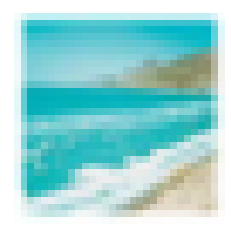

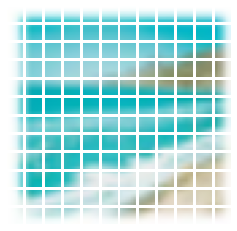

In [9]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(image_size, image_size))
patches = Patches(patch_size)(resized_image)

print(f"[INFO] Image size: {image_size} X {image_size}")
print(f"[INFO] Patch size: {patch_size} X {patch_size}")
print(f"[INFO] Patches per image: {patches.shape[1]}")
print(f"[INFO] Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Codificación de parches

La clase `PatchEncoder` transformará linealmente un parche proyectándolo en un vector de tamaño `projection_dim`. Además, agrega una una incrustación de posición aprendible en el vector proyectado.

In [10]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches,
                                                   output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Construcción del modelo ViT

El modelo ViT consta de varios bloques de transformadores,
que utilizan la capa `layers.MultiHeadAttention` como mecanismo de autoatención
aplicado a la secuencia de parches. Los bloques Transformer producen un
tensor `[batch_size, num_patches,projection_dim]`, que se procesa a través de un
cabeza clasificadora con softmax para producir la salida final de probabilidades de clase.

A diferencia de la técnica descrita en el *paper*, que antepone una incrustación aprendible a la secuencia de parches codificados para servir como la representación de la imagen, todas las salidas del bloque Transformador final son reformado con `layers.Flatten()` y usado como imagen entrada de representación a la cabeza del clasificador.

Se debe tener en cuenta que la capa `layers.GlobalAveragePooling1D` también podría usarse en su lugar para agregar las salidas del bloque Transformador,
especialmente cuando el número de parches y las dimensiones de proyección son grandes.

In [11]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Aumentación de datos
    augmented = data_augmentation(inputs)
    # Creación de parches
    patches = Patches(patch_size)(augmented)
    # Codificación de parches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Crea múltiples capas del bloque Transformador
    for _ in range(transformer_layers):
        # Capa de normalización 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Capa de atención de varias cabezas
        attention_output = layers.MultiHeadAttention(num_heads=num_heads,
                                                     key_dim=projection_dim,
                                                     dropout=0.1)(x1, x1)
        # Salto de conexión 1 (skip connection)
        x2 = layers.Add()([attention_output, encoded_patches])
        # Capa de normalización 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # Perceptrón Multicapa
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Salto de conexión 2 (skip connection)
        encoded_patches = layers.Add()([x3, x2])

    # Crea un tensor [batch_size, projection_dim]
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Añadir Perceptrón Multicapa
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Clasificar salidas
    logits = layers.Dense(num_classes)(features)
    # Crea el modelo
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

In [12]:
vit_classifier = create_vit_classifier()

## Entrenamiento del modelo

In [13]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

vit_classifier.compile(optimizer=optimizer,
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                                tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])

ckpt = tf.keras.callbacks.ModelCheckpoint(filepath='weights.{epoch:02d}-{val_accuracy:.2f}.h5',
                                          monitor="val_accuracy",
                                          save_best_only=True,
                                          save_weights_only=True)

In [14]:
%%time
num_epochs = 3
history = vit_classifier.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.1, callbacks=[ckpt])

Epoch 1/3
176/176 [==============================] - 96s 481ms/step - loss: 4.5140 - accuracy: 0.0414 - top-5-accuracy: 0.1492 - val_loss: 3.9181 - val_accuracy: 0.1014 - val_top-5-accuracy: 0.3056
Epoch 2/3
176/176 [==============================] - 83s 472ms/step - loss: 3.9755 - accuracy: 0.0888 - top-5-accuracy: 0.2806 - val_loss: 3.5733 - val_accuracy: 0.1616 - val_top-5-accuracy: 0.4072
Epoch 3/3
176/176 [==============================] - 83s 473ms/step - loss: 3.7066 - accuracy: 0.1288 - top-5-accuracy: 0.3639 - val_loss: 3.3437 - val_accuracy: 0.1980 - val_top-5-accuracy: 0.4726
CPU times: user 3min 42s, sys: 25.4 s, total: 4min 7s
Wall time: 4min 22s


In [23]:
vit_classifier.load_weights("weights.03-0.20.h5")
_, accuracy, top_5_accuracy = vit_classifier.evaluate(X_val, y_val)
print(f"[INFO] Validation accuracy: {round(accuracy * 100, 2)}%")
print(f"[INFO] Validation top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

313/313 [==============================] - 8s 24ms/step - loss: 3.3229 - accuracy: 0.2027 - top-5-accuracy: 0.4814
[INFO] Validation accuracy: 20.27%
[INFO] Validation top 5 accuracy: 48.14%


Después de 100 épocas, el modelo ViT logra alrededor del 55% de *accuracy* y
82% de *accuracy* en el top 5 en los datos de prueba. Estos no son resultados competitivos en el conjunto de datos CIFAR-100, ya que un ResNet50V2 entrenado desde cero con los mismos datos puede lograr un *accuracy* del 67%.

Nótese que los resultados del estado del arte informados en el paper se logran pre-entrenando el modelo ViT usando
el conjunto de datos JFT-300M, luego ajustándolo en el conjunto de datos de destino. Para mejorar la calidad del modelo.
sin entrenamiento previo, se puede intentar entrenar el modelo para más épocas, utilizando una mayor cantidad de capas Transformer, cambiando el tamaño de las imágenes de entrada, cambiando también el tamaño del parche o aumentando las dimensiones de proyección.

Además, como se menciona en el documento, la calidad del modelo se ve afectada no solo por las opciones de arquitectura, pero también por hiperparámetros como la tasa de aprendizaje, optimizador, decaimiento de peso, etc. En la práctica, se recomienda afinar un modelo ViT que fue pre-entrenado utilizando un gran conjunto de datos de alta resolución.